# Drought Data Aggregation Strategy

## 🎯 **Why We Aggregate Weekly → Monthly Data**

Our drought data comes in **weekly granularity** (1,345 weekly records from 2000-2025), but we need **monthly data** to merge with other datasets (fire, weather, population) that are all monthly.

## 🔥 **Why Maximum Drought Severity for Monthly Aggregation**

### **Wildfire Risk Perspective**
- **Fire Trigger Events**: Wildfires often start during the **worst drought conditions** of the month
- **Vegetation Stress**: Plants are most stressed during peak drought periods  
- **Soil Moisture**: Lowest soil moisture (worst drought) creates highest fire risk
- **Timing Matters**: A few days of extreme drought can trigger major fires
- **Risk Assessment**: For prediction, we want to know the **worst-case scenario** that month

### **Real-World Example**
- **Month**: July 2021
- **Week 1**: D1 (Moderate drought)
- **Week 2**: D2 (Severe drought) 
- **Week 3**: D3 (Extreme drought) ← **Fire starts here**
- **Week 4**: D1 (Moderate drought)

**Average**: D1.75 (Moderate-Severe) - misses the critical period
**Maximum**: D3 (Extreme) ← **This captures the actual fire risk!**

## 📊 **Data Processing Steps**

1. **Extract Year and Month**: Parse `MapDate` column (YYYYMMDD format)
2. **Group by Year-Month**: Aggregate weekly records into monthly
3. **Apply Maximum Logic**: Take the highest drought severity for each month
4. **Create Clean Dataset**: Monthly drought data ready for merging

## ✅ **Benefits of This Approach**

- **Captures Critical Periods**: Identifies worst drought conditions that trigger fires
- **Conservative Risk Assessment**: Better safe than sorry for emergency planning
- **Aligns with Emergency Management**: Matches how fire agencies think about drought risk
- **Consistent Granularity**: Monthly data matches other datasets for clean merging


# California Drought Data Ingestion

**Dataset**: US Drought Monitor - California  
**Date Range**: 2000 - 2025  
**Source**: [US Drought Monitor](https://droughtmonitor.unl.edu/)

**Objective**: 
- Load and validate weekly drought severity data
- Verify data quality and temporal coverage
- Understand dataset structure and drought categories (D0-D4)
- Document drought conditions during January 2025 fires
- Prepare for comprehensive EDA in Phase 2


## Why Drought Data Matters for Fire Prediction

Drought is a long-term drying process that creates fundamental conditions for catastrophic wildfires. Unlike daily weather, drought represents sustained moisture deficits.

**1. Fuel Moisture Depletion**: Progressive drying reduces vegetation moisture over weeks/months. Severe drought means critically dry fuels.

**2. Long-Term Risk Indicator**: Drought observable weeks/months before fires, providing early warning.

**3. California Drought Cycles**: Multi-year droughts (2012-2016) preceded massive fire seasons. Mediterranean climate with natural dry summers.

**4. Cumulative Effect**: Each drought week compounds fire risk. D2+ drought = high fire danger.

**5. Synergy with Weather**: Drought + Heat + Wind = Extreme conditions (January 2025 scenario).

**Key Insight**: January 2025 fires followed months of below-normal rainfall. Tracking drought severity predicts when fuels reach critically low moisture.


### Dataset Features Explained

#### Drought Severity Categories (Categorical Features):

| Feature | Type | Values | Meaning | Fire Risk Impact |
|---------|------|--------|---------|------------------|
| **None** | Categorical | 0-100% | Percent of area with NO drought | Safe - Normal fuel moisture |
| **D0** | Categorical | 0-100% | Abnormally Dry | **Low** - Fuels starting to dry, minor stress |
| **D1** | Categorical | 0-100% | Moderate Drought | **Moderate** - Vegetation stress, reduced moisture |
| **D2** | Categorical | 0-100% | Severe Drought | **High** - Critically dry fuels, fire danger |
| **D3** | Categorical | 0-100% | Extreme Drought | **Very High** - Explosive fire potential |
| **D4** | Categorical | 0-100% | Exceptional Drought | **Extreme** - Catastrophic fire conditions |

**Value Interpretation**:
- Each value represents the **percentage of California's area** in that drought category for that week
- Example: D2 = 45% means 45% of California is experiencing Severe Drought
- Values sum to approximately 100% across all categories (None + D0 + D1 + D2 + D3 + D4)

#### Temporal Features:

| Feature | Type | Format | Meaning |
|---------|------|--------|---------|
| **ValidStart** | Date | YYYY-MM-DD | Start date of drought measurement week |
| **ValidEnd** | Date | YYYY-MM-DD | End date of drought measurement week |
| **MapDate** | Date | YYYYMMDD | Date drought map was released |

**Frequency**: Weekly measurements (every Tuesday)

#### Geographic Features:

| Feature | Type | Values | Meaning |
|---------|------|--------|---------|
| **FIPS** | Categorical | 06 | Federal Information Processing Standard code for California |
| **State** | Categorical | CA | State abbreviation |
| **County** | Categorical | Name | County name (if county-level data) |

#### Derived Features for Model:

From this drought data, we can create powerful predictive features:

1. **Current Drought Level** = Highest active drought category (D0-D4)
2. **Drought Intensity Score** = Weighted sum (D1×1 + D2×2 + D3×3 + D4×4)
3. **Weeks in Drought** = Consecutive weeks with D1+ drought
4. **Drought Trend** = Is drought worsening or improving?
5. **Severe Drought Area** = % of area in D2+ (critical threshold)
6. **Drought Duration** = How many months of sustained drought
7. **Seasonal Drought Pattern** = Drought level by season
8. **Multi-year Drought Indicator** = Drought persisting across years

#### Data Source Details:
- **Agency**: National Drought Mitigation Center (University of Nebraska-Lincoln)
- **URL**: [Drought Monitor Data](https://droughtmonitor.unl.edu/DmData/DataDownload.aspx)
- **Methodology**: Based on precipitation, temperature, soil moisture, streamflow, and vegetation health indices
- **Update Frequency**: Weekly (every Thursday)
- **Reliability**: Used by USDA, NOAA, and federal agencies for drought assessment


In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("✅ Libraries imported!")


/Users/ccfi-capp/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


✅ Libraries imported!


## 1. Load Drought Data


In [2]:
# Load drought data
drought_file = Path('../data/raw/drought/california_drought_2000_2025.csv')

print(f"Loading drought data from: {drought_file}")
print(f"File exists: {drought_file.exists()}")

drought_df = pd.read_csv(drought_file)
print(f"\n✅ Loaded {len(drought_df):,} weekly drought records!")
print(f"\nColumns: {drought_df.columns.tolist()}")
print(f"\nFirst 5 records:")
drought_df.head()


Loading drought data from: ../data/raw/drought/california_drought_2000_2025.csv
File exists: True

✅ Loaded 1,345 weekly drought records!

Columns: ['MapDate', 'StateAbbreviation', 'None', 'D0', 'D1', 'D2', 'D3', 'D4', 'ValidStart', 'ValidEnd', 'StatisticFormatID']

First 5 records:


MapDate StateAbbreviation   None     D0     D1     D2    D3   D4  \
0  20251007                CA  27.20  34.28  22.88  14.39  1.25  0.0   
1  20250930                CA  26.78  34.70  19.91  17.36  1.25  0.0   
2  20250923                CA  26.78  34.70  19.67  17.60  1.25  0.0   
3  20250916                CA  26.78  33.67  16.55  19.51  3.49  0.0   
4  20250909                CA  23.99  36.45  16.55  19.12  3.88  0.0   

   ValidStart    ValidEnd  StatisticFormatID  
0  2025-10-07  2025-10-13                  2  
1  2025-09-30  2025-10-06                  2  
2  2025-09-23  2025-09-29                  2  
3  2025-09-16  2025-09-22                  2  
4  2025-09-09  2025-09-15                  2

## 2. Drought Visualizations


DROUGHT DATA VISUALIZATIONS


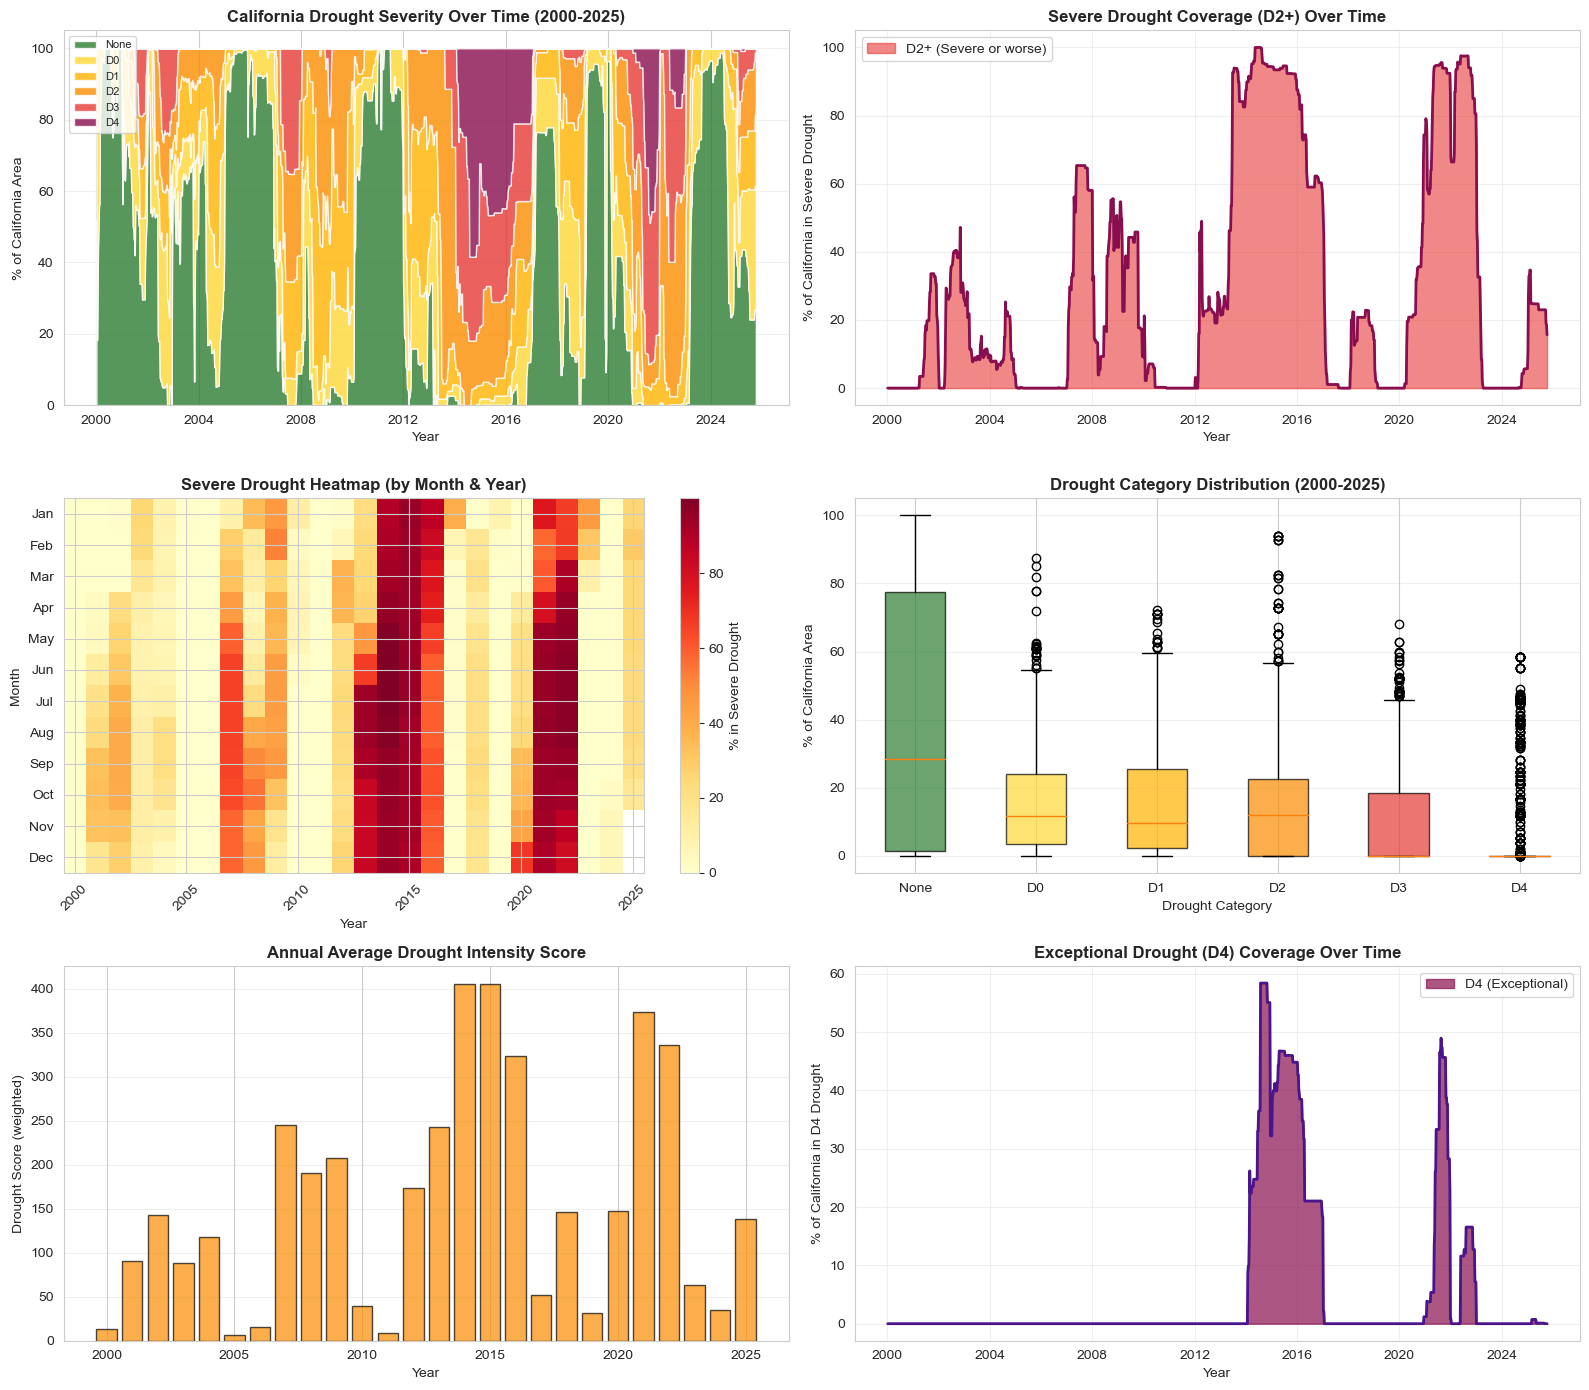


✅ Drought visualizations complete!


In [3]:
# Parse dates
drought_df['ValidStart'] = pd.to_datetime(drought_df['ValidStart'])
drought_df['ValidEnd'] = pd.to_datetime(drought_df['ValidEnd'])
drought_df['MapDate'] = pd.to_datetime(drought_df['MapDate'], format='%Y%m%d')

# Sort by date
drought_df = drought_df.sort_values('ValidStart').reset_index(drop=True)

print("=" * 80)
print("DROUGHT DATA VISUALIZATIONS")
print("=" * 80)

# Create comprehensive drought visualizations
fig, axes = plt.subplots(3, 2, figsize=(16, 14))

# 1. Drought Severity Over Time (Stacked Area)
drought_categories = ['None', 'D0', 'D1', 'D2', 'D3', 'D4']
colors = ['#2E7D32', '#FDD835', '#FFB300', '#FB8C00', '#E53935', '#880E4F']
axes[0, 0].stackplot(drought_df['ValidStart'], 
                     drought_df['None'], drought_df['D0'], drought_df['D1'], 
                     drought_df['D2'], drought_df['D3'], drought_df['D4'],
                     labels=drought_categories, colors=colors, alpha=0.8)
axes[0, 0].set_title('California Drought Severity Over Time (2000-2025)', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('% of California Area')
axes[0, 0].set_xlabel('Year')
axes[0, 0].legend(loc='upper left', fontsize=8)
axes[0, 0].grid(True, alpha=0.3, axis='y')

# 2. Severe Drought (D2+) Trend
drought_df['Severe_Drought'] = drought_df['D2'] + drought_df['D3'] + drought_df['D4']
axes[0, 1].fill_between(drought_df['ValidStart'], drought_df['Severe_Drought'], 
                        color='#E53935', alpha=0.6, label='D2+ (Severe or worse)')
axes[0, 1].plot(drought_df['ValidStart'], drought_df['Severe_Drought'], 
                color='#880E4F', linewidth=2)
axes[0, 1].set_title('Severe Drought Coverage (D2+) Over Time', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('% of California in Severe Drought')
axes[0, 1].set_xlabel('Year')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Drought Heatmap (by Year and Month)
drought_df['Year'] = drought_df['ValidStart'].dt.year
drought_df['Month'] = drought_df['ValidStart'].dt.month

# Calculate average severe drought by year and month
drought_pivot = drought_df.groupby(['Year', 'Month'])['Severe_Drought'].mean().unstack()
im = axes[1, 0].imshow(drought_pivot.T, cmap='YlOrRd', aspect='auto', interpolation='nearest')
axes[1, 0].set_title('Severe Drought Heatmap (by Month & Year)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Year')
axes[1, 0].set_ylabel('Month')
axes[1, 0].set_yticks(range(12))
axes[1, 0].set_yticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                             'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
axes[1, 0].set_xticks(range(0, len(drought_pivot.index), 5))
axes[1, 0].set_xticklabels(drought_pivot.index[::5], rotation=45)
plt.colorbar(im, ax=axes[1, 0], label='% in Severe Drought')

# 4. Drought Category Distribution (Boxplot)
drought_long = pd.melt(drought_df[['None', 'D0', 'D1', 'D2', 'D3', 'D4']], 
                       var_name='Category', value_name='Percentage')
category_order = ['None', 'D0', 'D1', 'D2', 'D3', 'D4']
bp = axes[1, 1].boxplot([drought_long[drought_long['Category'] == cat]['Percentage'].values 
                          for cat in category_order],
                         labels=category_order, patch_artist=True)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[1, 1].set_title('Drought Category Distribution (2000-2025)', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('% of California Area')
axes[1, 1].set_xlabel('Drought Category')
axes[1, 1].grid(True, alpha=0.3, axis='y')

# 5. Annual Drought Intensity Score
drought_df['Drought_Score'] = (drought_df['D0'] * 1 + drought_df['D1'] * 2 + 
                                drought_df['D2'] * 3 + drought_df['D3'] * 4 + 
                                drought_df['D4'] * 5)
annual_drought = drought_df.groupby('Year')['Drought_Score'].mean()
axes[2, 0].bar(annual_drought.index, annual_drought.values, 
               color='#FB8C00', alpha=0.7, edgecolor='black')
axes[2, 0].set_title('Annual Average Drought Intensity Score', fontsize=12, fontweight='bold')
axes[2, 0].set_ylabel('Drought Score (weighted)')
axes[2, 0].set_xlabel('Year')
axes[2, 0].grid(True, alpha=0.3, axis='y')

# 6. Exceptional Drought (D4) Timeline
axes[2, 1].fill_between(drought_df['ValidStart'], drought_df['D4'], 
                        color='#880E4F', alpha=0.7, label='D4 (Exceptional)')
axes[2, 1].plot(drought_df['ValidStart'], drought_df['D4'], 
                color='#4A148C', linewidth=2)
axes[2, 1].set_title('Exceptional Drought (D4) Coverage Over Time', fontsize=12, fontweight='bold')
axes[2, 1].set_ylabel('% of California in D4 Drought')
axes[2, 1].set_xlabel('Year')
axes[2, 1].legend()
axes[2, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Drought visualizations complete!")
print("=" * 80)


In [4]:
# Load drought data
drought_file = Path('../data/raw/drought/california_drought_2000_2025.csv')

print(f"Loading drought data from: {drought_file}")
print(f"File exists: {drought_file.exists()}")

drought_df = pd.read_csv(drought_file)
print(f"\n✅ Loaded {len(drought_df):,} weekly drought records!")
print(f"\nColumns: {drought_df.columns.tolist()}")
print(f"\nFirst 5 records:")
drought_df.head()


Loading drought data from: ../data/raw/drought/california_drought_2000_2025.csv
File exists: True

✅ Loaded 1,345 weekly drought records!

Columns: ['MapDate', 'StateAbbreviation', 'None', 'D0', 'D1', 'D2', 'D3', 'D4', 'ValidStart', 'ValidEnd', 'StatisticFormatID']

First 5 records:


MapDate StateAbbreviation   None     D0     D1     D2    D3   D4  \
0  20251007                CA  27.20  34.28  22.88  14.39  1.25  0.0   
1  20250930                CA  26.78  34.70  19.91  17.36  1.25  0.0   
2  20250923                CA  26.78  34.70  19.67  17.60  1.25  0.0   
3  20250916                CA  26.78  33.67  16.55  19.51  3.49  0.0   
4  20250909                CA  23.99  36.45  16.55  19.12  3.88  0.0   

   ValidStart    ValidEnd  StatisticFormatID  
0  2025-10-07  2025-10-13                  2  
1  2025-09-30  2025-10-06                  2  
2  2025-09-23  2025-09-29                  2  
3  2025-09-16  2025-09-22                  2  
4  2025-09-09  2025-09-15                  2

# Drought Data Aggregation Strategy

## 🎯 **Why We Aggregate Weekly → Monthly Data**

The US Drought Monitor data comes in **weekly granularity** (1,345 weekly records from 2000-2025), but we need **monthly data** to merge with other datasets (fire, weather, population) that are all monthly.

## 🔥 **Why Maximum Drought Severity for Monthly Aggregation**

### **Wildfire Risk Perspective**
- **Fire Trigger Events**: Wildfires often start during the **worst drought conditions** of the month
- **Vegetation Stress**: Plants are most stressed during peak drought periods  
- **Soil Moisture**: Lowest soil moisture (worst drought) creates highest fire risk
- **Timing Matters**: A few days of extreme drought can trigger major fires
- **Risk Assessment**: For prediction, we want to know the **worst-case scenario** that month

### **Real-World Example**
- **Month**: July 2021
- **Week 1**: D1 (Moderate drought)
- **Week 2**: D2 (Severe drought) 
- **Week 3**: D3 (Extreme drought) ← **Fire starts here**
- **Week 4**: D1 (Moderate drought)

**Average**: D1.75 (Moderate-Severe) - misses the critical period
**Maximum**: D3 (Extreme) ← **This captures the actual fire risk!**

## 📊 **Data Processing Steps**

1. **Extract Year and Month**: Parse `MapDate` column (YYYYMMDD format)
2. **Group by Year-Month**: Aggregate weekly records into monthly
3. **Apply Maximum Logic**: Take the highest drought severity for each month
4. **Create Clean Dataset**: Monthly drought data ready for merging

## ✅ **Benefits of This Approach**

- **Captures Critical Periods**: Identifies worst drought conditions that trigger fires
- **Conservative Risk Assessment**: Better safe than sorry for emergency planning
- **Aligns with Emergency Management**: Matches how fire agencies think about drought risk
- **Consistent Granularity**: Monthly data matches other datasets for clean merging


In [5]:
# Extract Year and Month from MapDate and Aggregate to Monthly Data
print('='*60)
print('DROUGHT DATA AGGREGATION: WEEKLY → MONTHLY')
print('='*60)

# Step 1: Parse MapDate to extract Year and Month
print('Step 1: Extracting Year and Month from MapDate...')
drought_df['MapDate'] = drought_df['MapDate'].astype(str)
drought_df['Year'] = drought_df['MapDate'].str[:4].astype(int)
drought_df['Month'] = drought_df['MapDate'].str[4:6].astype(int)

print(f'✅ Extracted Year and Month columns')
print(f'   Date range: {drought_df["Year"].min()}-{drought_df["Year"].max()}')
print(f'   Months: {sorted(drought_df["Month"].unique())}')

# Step 2: Aggregate weekly data to monthly using MAXIMUM drought severity
print('\nStep 2: Aggregating weekly data to monthly using MAXIMUM drought severity...')

# Group by Year and Month, then take the maximum value for each drought category
monthly_drought = drought_df.groupby(['Year', 'Month']).agg({
    'None': 'max',      # Maximum percentage with no drought
    'D0': 'max',        # Maximum percentage in D0 (Abnormally Dry)
    'D1': 'max',        # Maximum percentage in D1 (Moderate Drought)
    'D2': 'max',        # Maximum percentage in D2 (Severe Drought)
    'D3': 'max',        # Maximum percentage in D3 (Extreme Drought)
    'D4': 'max'         # Maximum percentage in D4 (Exceptional Drought)
}).reset_index()

print(f'✅ Aggregated to monthly data')
print(f'   Monthly records: {len(monthly_drought):,}')
print(f'   Date range: {monthly_drought["Year"].min()}-{monthly_drought["Year"].max()}')

# Step 3: Create additional drought features for model
print('\nStep 3: Creating additional drought features...')

# Calculate drought intensity score (weighted by severity)
monthly_drought['Drought_Intensity_Score'] = (
    monthly_drought['D1'] * 1 + 
    monthly_drought['D2'] * 2 + 
    monthly_drought['D3'] * 3 + 
    monthly_drought['D4'] * 4
)

# Calculate percentage of area in severe drought (D2+)
monthly_drought['Severe_Drought_Area'] = (
    monthly_drought['D2'] + 
    monthly_drought['D3'] + 
    monthly_drought['D4']
)

# Create binary indicators for each drought level
monthly_drought['Has_D0'] = (monthly_drought['D0'] > 0).astype(int)
monthly_drought['Has_D1'] = (monthly_drought['D1'] > 0).astype(int)
monthly_drought['Has_D2'] = (monthly_drought['D2'] > 0).astype(int)
monthly_drought['Has_D3'] = (monthly_drought['D3'] > 0).astype(int)
monthly_drought['Has_D4'] = (monthly_drought['D4'] > 0).astype(int)

print(f'✅ Created additional drought features:')
print(f'   - Drought_Intensity_Score (weighted severity)')
print(f'   - Severe_Drought_Area (D2+ percentage)')
print(f'   - Binary indicators for each drought level')

# Step 4: Display sample of monthly aggregated data
print(f'\nStep 4: Sample of monthly drought data:')
print(monthly_drought.head(10))

# Step 5: Save monthly drought data
print(f'\nStep 5: Saving monthly drought data...')
output_dir = Path('../data/processed')
output_dir.mkdir(parents=True, exist_ok=True)

monthly_drought_file = output_dir / 'drought_data_monthly_2000_2025.csv'
monthly_drought.to_csv(monthly_drought_file, index=False)

print(f'✅ Monthly drought data saved to: {monthly_drought_file}')
print(f'   File size: {monthly_drought_file.stat().st_size / (1024*1024):.2f} MB')
print(f'   Records: {len(monthly_drought):,} monthly records')

# Step 6: Summary statistics
print(f'\n📊 MONTHLY DROUGHT DATA SUMMARY:')
print(f'   Date range: {monthly_drought["Year"].min()}-{monthly_drought["Year"].max()}')
print(f'   Total months: {len(monthly_drought):,}')
print(f'   Years covered: {monthly_drought["Year"].nunique()}')
print(f'   Average drought intensity: {monthly_drought["Drought_Intensity_Score"].mean():.2f}')
print(f'   Months with severe drought (D2+): {(monthly_drought["Severe_Drought_Area"] > 0).sum():,}')

print(f'\n🎯 Monthly drought data ready for merging with other datasets!')


DROUGHT DATA AGGREGATION: WEEKLY → MONTHLY
Step 1: Extracting Year and Month from MapDate...
✅ Extracted Year and Month columns
   Date range: 2000-2025
   Months: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

Step 2: Aggregating weekly data to monthly using MAXIMUM drought severity...
✅ Aggregated to monthly data
   Monthly records: 310
   Date range: 2000-2025

Step 3: Creating additional drought features...
✅ Created additional drought features:
   - Drought_Intensity_Score (weighted severity)
   - Severe_Drought_Area (D2+ percentage)
   - Binary indicators for each drought level

Step 4: Sample of monthly drought data:
   Year  Month    None     D0    D1   D2   D3   D4  Drought_Intensity_Score  \
0  2000      1   51.83  81.75  0.00  0.0  0.0  0.0                     0.00   
1  2000      2   83.71  50.88  0.05  0.0  0.0  0.0                     0.05   
2  2000      3   97.45   9.40  0.03  0.0  0.0  0.0                     0.03   
3  2000      4  100.00   4.07  0.00  0.0  0.0  0.0        